In [1]:
from pynq import Overlay
from pynq import allocate

In [2]:
import numpy as np
import cv2
from IPython import display
from time import time
from time import sleep
import matplotlib.pyplot as plt
# import torch
# from torchvision import transforms


In [3]:
# ===== function for validation =====

def Validate_file(ourOutput, golden, size, fp):
    """
    Validate the output of the HLS IP against the golden output
    """
    errors = 0
    N, C, D, H, W = size[0], size[1], size[2], size[3], size[4]
    for n in range(N):
        for c in range(C):
            for d in range(D):
                for h in range(H):
                    for w in range(W):
                        pos = n * C*D*H*W + c * D*H*W + d * H*W + h * W + w
                        if ourOutput[pos] != golden[pos]:
                            print(f'[ERROR]  result[{n+1:3.0f}][{c+1:3.0f}][{d+1:3.0f}][{h+1:3.0f}][{w+1:3.0f}] = {ourOutput[pos]:3.0f}, gold: {golden[pos]:3.0f}, error: {ourOutput[pos] - golden[pos]}', file=fp)
                            errors += 1
    if(errors == 0):
        print(f'Validation passed! all results are the same', file=fp)
    return errors

In [4]:
# ===== function to load data from files =====

def CountArr(filename):
    """
    Count the number of data in the file "filename"
    """
    with open(filename) as f:
        num = 0
        line = f.readline()
        while line:
            num += 1
            line = f.readline()
    return num

def LoadArr(filename, type):
    """
    Load the data array from the file "filename" into a PL numpy array of type "type"
    """
    num = CountArr(filename)
    arr = allocate(shape=(num,), dtype=type)
    with open(filename) as f:
        line = f.readline()
        num = 0
        while line:
            arr[num] = type(np.float32(line))
            num += 1
            line = f.readline()
    return arr

def LoadNpArr(filename, type):
    """
    Load the data array from the file "filename" into a PL numpy array of type "type"
    """
    num = CountArr(filename)
    arr = []
    with open(filename) as f:
        line = f.readline()
        num = 0
        while line:
            arr = arr.append(type(np.float32(line)))
            num += 1
            line = f.readline()
    return np.array(arr, dtype=type)

def SaveNpArr(filename, arr):
    """
    Save the data array from the file "filename" into a PL numpy array of type "type"
    """
    with open(filename, 'w') as f:
        for i in range(len(arr)):
            print(arr[i], file=f)

In [62]:
# ===== function about video =====

def RecordVideo(mode='INF', length=0):
    """
    Record video from the camera and return a numpy array
    """
    # setup the camera
    cap = cv2.VideoCapture(-1)
    print('Camera setting:')
    print('  width: ', cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    print('  height: ', cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print('  fps: ', cap.get(cv2.CAP_PROP_FPS))

    print('Start recording...')
    # record video
    frames = []

    if (mode == 'FRAME'):
        print('mode: FRAME, length:', length, 'frames')
        ret, frame = cap.read()
        while (len(frames) < length):
            frames.append(frame)
            ret, frame = cap.read()
    else:
        print('mode: INF, need to stop manually')
        try:
            ret, frame = cap.read()
            while (ret == True):
                frames.append(frame)
                ret, frame = cap.read()
        except KeyboardInterrupt:
            pass

    cap.release()
    print('Stop recording...')
    return np.array(frames, dtype=np.uint8)

def ShowVideo(frames, fps=30):
    """
    Show the video in the notebook
    """
    for i in range(len(frames)):
        # some block magic
        _, ret_array = cv2.imencode('.jpg', frames[i])
        display.clear_output(wait=True)
        display.display(display.Image(data=ret_array))
        sleep(1/fps)
        

In [6]:
# ===== allocate buffer_tensor_tensor_tensor_tensors =====

my_input = allocate(shape=(602112), dtype=np.uint8)
output = allocate(shape=(10,), dtype=np.uint8)

X_stem_1 = allocate(shape=(2257920,), dtype=np.uint8)
X_stem_2 = allocate(shape=(3211264,), dtype=np.uint8)
X_data = allocate(shape=(3211264,), dtype=np.uint8)
X2_data = allocate(shape=(802816,), dtype=np.uint8)
X3_data = allocate(shape=(200704,), dtype=np.uint8)
X_seq = allocate(shape=(50176,), dtype=np.uint8)
X_tmp_data = allocate(shape=(3211264,), dtype=np.uint8)
X_batch_data = allocate(shape=(7225344,), dtype=np.uint8)
X_mid_data = allocate(shape=(7225344,), dtype=np.uint8)

In [7]:
# ===== allocate and load kernel data =====

Kernel_stem_0 = LoadArr('stem.0.weight.dat', np.int8)
Kernel_stem_3 = LoadArr('stem.3.weight.dat', np.int8)

Kernel_seq1_0_conv1_0_0 = LoadArr('layer1.0.conv1.0.0.weight.dat', np.int8)
Kernel_seq1_0_conv2_0_0 = LoadArr('layer1.0.conv2.0.0.weight.dat', np.int8)
Kernel_seq1_1_conv1_0_0 = LoadArr('layer1.1.conv1.0.0.weight.dat', np.int8)
Kernel_seq1_1_conv2_0_0 = LoadArr('layer1.1.conv2.0.0.weight.dat', np.int8)
Kernel_seq1_0_conv1_0_3 = LoadArr('layer1.0.conv1.0.3.weight.dat', np.int8)
Kernel_seq1_0_conv2_0_3 = LoadArr('layer1.0.conv2.0.3.weight.dat', np.int8)
Kernel_seq1_1_conv1_0_3 = LoadArr('layer1.1.conv1.0.3.weight.dat', np.int8)
Kernel_seq1_1_conv2_0_3 = LoadArr('layer1.1.conv2.0.3.weight.dat', np.int8)

Kernel_seq2_0_conv1_0_0 = LoadArr('layer2.0.conv1.0.0.weight.dat', np.int8)
Kernel_seq2_0_conv1_0_3 = LoadArr('layer2.0.conv1.0.3.weight.dat', np.int8)
Kernel_seq2_0_conv2_0_0 = LoadArr('layer2.0.conv2.0.0.weight.dat', np.int8)
Kernel_seq2_0_conv2_0_3 = LoadArr('layer2.0.conv2.0.3.weight.dat', np.int8)
Kernel_seq2_0_downsample_0 = LoadArr('layer2.0.downsample.0.weight.dat', np.int8)
Kernel_seq2_1_conv1_0_0 = LoadArr('layer2.1.conv1.0.0.weight.dat', np.int8)
Kernel_seq2_1_conv1_0_3 = LoadArr('layer2.1.conv1.0.3.weight.dat', np.int8)
Kernel_seq2_1_conv2_0_0 = LoadArr('layer2.1.conv2.0.0.weight.dat', np.int8)
Kernel_seq2_1_conv2_0_3 = LoadArr('layer2.1.conv2.0.3.weight.dat', np.int8)

Kernel_seq3_0_conv1_0_0 = LoadArr('layer3.0.conv1.0.0.weight.dat', np.int8)
Kernel_seq3_0_conv1_0_3 = LoadArr('layer3.0.conv1.0.3.weight.dat', np.int8)
Kernel_seq3_0_conv2_0_0 = LoadArr('layer3.0.conv2.0.0.weight.dat', np.int8)
Kernel_seq3_0_conv2_0_3 = LoadArr('layer3.0.conv2.0.3.weight.dat', np.int8)
Kernel_seq3_0_downsample_0 = LoadArr('layer3.0.downsample.0.weight.dat', np.int8)
Kernel_seq3_1_conv1_0_0 = LoadArr('layer3.1.conv1.0.0.weight.dat', np.int8)
Kernel_seq3_1_conv1_0_3 = LoadArr('layer3.1.conv1.0.3.weight.dat', np.int8)
Kernel_seq3_1_conv2_0_0 = LoadArr('layer3.1.conv2.0.0.weight.dat', np.int8)
Kernel_seq3_1_conv2_0_3 = LoadArr('layer3.1.conv2.0.3.weight.dat', np.int8)

Kernel_seq4_0_conv1_0_0 = LoadArr('layer4.0.conv1.0.0.weight.dat', np.int8)
Kernel_seq4_0_conv1_0_3 = LoadArr('layer4.0.conv1.0.3.weight.dat', np.int8)
Kernel_seq4_0_conv2_0_0 = LoadArr('layer4.0.conv2.0.0.weight.dat', np.int8)
Kernel_seq4_0_conv2_0_3 = LoadArr('layer4.0.conv2.0.3.weight.dat', np.int8)
Kernel_seq4_0_downsample_0 = LoadArr('layer4.0.downsample.0.weight.dat', np.int8)
Kernel_seq4_1_conv1_0_0 = LoadArr('layer4.1.conv1.0.0.weight.dat', np.int8)
Kernel_seq4_1_conv1_0_3 = LoadArr('layer4.1.conv1.0.3.weight.dat', np.int8)
Kernel_seq4_1_conv2_0_0 = LoadArr('layer4.1.conv2.0.0.weight.dat', np.int8)
Kernel_seq4_1_conv2_0_3 = LoadArr('layer4.1.conv2.0.3.weight.dat', np.int8)

Kernel_linear = LoadArr('fc.1.weight.dat', np.int8)

In [8]:
# ===== setup ip =====

# load ip
ol = Overlay("./bitstreams/r2plus1d_v15.5_cnt.bit")
ip_r2plus1d = ol.r2plus1d_0

# write input address
ip_r2plus1d.write(0x10, my_input.device_address)
# write output address
ip_r2plus1d.write(0x22C, output.device_address)
# write kernel address
ip_r2plus1d.write(0x1C, Kernel_stem_0.device_address)
ip_r2plus1d.write(0x28, Kernel_stem_3.device_address)
ip_r2plus1d.write(0x34, Kernel_seq1_0_conv1_0_0.device_address)
ip_r2plus1d.write(0x40, Kernel_seq1_0_conv1_0_3.device_address)
ip_r2plus1d.write(0x4C, Kernel_seq1_0_conv2_0_0.device_address)
ip_r2plus1d.write(0x58, Kernel_seq1_0_conv2_0_3.device_address)
ip_r2plus1d.write(0x64, Kernel_seq1_1_conv1_0_0.device_address)
ip_r2plus1d.write(0x70, Kernel_seq1_1_conv1_0_3.device_address)
ip_r2plus1d.write(0x7C, Kernel_seq1_1_conv2_0_0.device_address)
ip_r2plus1d.write(0x88, Kernel_seq1_1_conv2_0_3.device_address)
ip_r2plus1d.write(0x94, Kernel_seq2_0_conv1_0_0.device_address)
ip_r2plus1d.write(0xA0, Kernel_seq2_0_conv1_0_3.device_address)
ip_r2plus1d.write(0xAC, Kernel_seq2_0_conv2_0_0.device_address)
ip_r2plus1d.write(0xB8, Kernel_seq2_0_conv2_0_3.device_address)
ip_r2plus1d.write(0xC4, Kernel_seq2_0_downsample_0.device_address)
ip_r2plus1d.write(0xD0, Kernel_seq2_1_conv1_0_0.device_address)
ip_r2plus1d.write(0xDC, Kernel_seq2_1_conv1_0_3.device_address)
ip_r2plus1d.write(0xE8, Kernel_seq2_1_conv2_0_0.device_address)
ip_r2plus1d.write(0xF4, Kernel_seq2_1_conv2_0_3.device_address)
ip_r2plus1d.write(0x100, Kernel_seq3_0_conv1_0_0.device_address)
ip_r2plus1d.write(0x10C, Kernel_seq3_0_conv1_0_3.device_address)
ip_r2plus1d.write(0x118, Kernel_seq3_0_conv2_0_0.device_address)
ip_r2plus1d.write(0x124, Kernel_seq3_0_conv2_0_3.device_address)
ip_r2plus1d.write(0x130, Kernel_seq3_0_downsample_0.device_address)
ip_r2plus1d.write(0x13C, Kernel_seq3_1_conv1_0_0.device_address)
ip_r2plus1d.write(0x148, Kernel_seq3_1_conv1_0_3.device_address)
ip_r2plus1d.write(0x154, Kernel_seq3_1_conv2_0_0.device_address)
ip_r2plus1d.write(0x160, Kernel_seq3_1_conv2_0_3.device_address)
ip_r2plus1d.write(0x16C, Kernel_seq4_0_conv1_0_0.device_address)
ip_r2plus1d.write(0x178, Kernel_seq4_0_conv1_0_3.device_address)
ip_r2plus1d.write(0x184, Kernel_seq4_0_conv2_0_0.device_address)
ip_r2plus1d.write(0x190, Kernel_seq4_0_conv2_0_3.device_address)
ip_r2plus1d.write(0x19C, Kernel_seq4_0_downsample_0.device_address)
ip_r2plus1d.write(0x1A8, Kernel_seq4_1_conv1_0_0.device_address)
ip_r2plus1d.write(0x1B4, Kernel_seq4_1_conv1_0_3.device_address)
ip_r2plus1d.write(0x1C0, Kernel_seq4_1_conv2_0_0.device_address)
ip_r2plus1d.write(0x1CC, Kernel_seq4_1_conv2_0_3.device_address)
ip_r2plus1d.write(0x1D8, Kernel_linear.device_address)
# write buffer address
ip_r2plus1d.write(0x1E4, X_stem_1.device_address)      # stem.2 ouptut
ip_r2plus1d.write(0x1F0, X_stem_2.device_address)      # layer1 output
ip_r2plus1d.write(0x1FC, X_data.device_address)      
ip_r2plus1d.write(0x208, X2_data.device_address)       # layer2 output
ip_r2plus1d.write(0x214, X3_data.device_address)       # layer3 output
ip_r2plus1d.write(0x220, X_seq.device_address)         # layer4 output
ip_r2plus1d.write(0x238, X_tmp_data.device_address)    # layer1 output
ip_r2plus1d.write(0x244, X_batch_data.device_address)  # layer1.1.relu input
ip_r2plus1d.write(0x250, X_mid_data.device_address)    # layer1.1.conv2.0.2 output

In [101]:
# ===== recording input video =====

# INF mode: need to interrupt manually
# FRAME mode: need to set frame number
input_video = RecordVideo(mode='INF')
# input_video = RecordVideo(mode='FRAME', length=100)

Camera setting:
  width:  640.0
  height:  480.0
  fps:  30.0
Start recording...
mode: INF, need to stop manually
Stop recording...


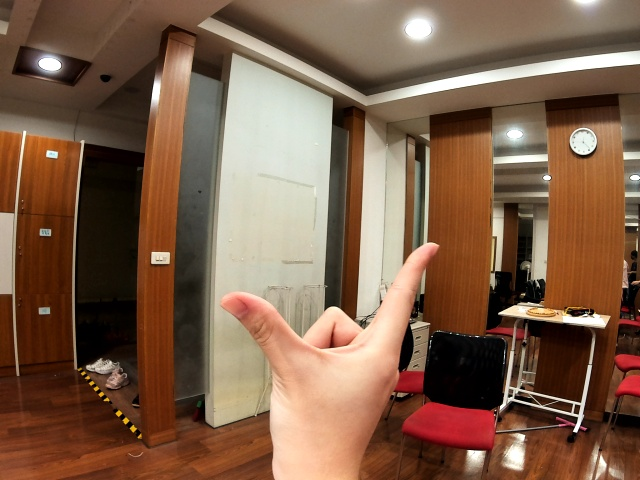

shape before cut: (6, 480, 640, 3)
shape before cut: (3, 480, 640, 3)


In [129]:
# ===== play and store input video =====

# only for check
ShowVideo(input_video, 30)

# cut video to get middle part
print('shape before cut:', input_video.shape)
num_frame = input_video.shape[0]
input_video = input_video[int(num_frame/5):int(num_frame*4/5)]
print('shape before cut:', input_video.shape)

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('record.mp4', fourcc, 30, (640, 480))

for i in range(len(input_video)):
    out.write(input_video[i])
out.release()

In [134]:
def linspace_sampling(num_frames, num_samples):

    idx = list(np.linspace(0, num_frames-1, num_samples))
    frame_indices = [int(i) for i in idx]

    return frame_indices

# initialize a VideoCapture object to read video data into a numpy array
capture = cv2.VideoCapture('videos/record_7.mp4')
original_frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
# create a buffer. Must have dtype float, so it gets converted to a FloatTensor by Pytorch later

# Sampling
frame_count = 16
frame_indices = linspace_sampling(original_frame_count, frame_count)

buffer = np.zeros(
    (frame_count, 112, 112, 3))

for i, v in enumerate(frame_indices):
    capture.set(cv2.CAP_PROP_POS_FRAMES, v)
    retaining, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # transform
    frame = cv2.resize(frame, (112, 112), interpolation=cv2.INTER_AREA)
    # normalize frame with mean = (0.485, 0.456, 0.406), and std = (0.229, 0.224, 0.225)
    frame = frame.astype(np.float32)
    frame = frame / 255.0
    frame = (frame - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
    buffer[i] = frame

# release the VideoCapture once it is no longer needed
capture.release()

# convert from [D, H, W, C] format to [C, D, H, W] (what PyTorch uses)
# D = Depth (in this case, time), H = Height, W = Width, C = Channels
buffer = np.swapaxes(buffer, 0, 3)
buffer = np.swapaxes(buffer, 1, 3)
buffer = np.swapaxes(buffer, 2, 3)
print('type(buffer):', type(buffer))
print('buffer.shape:', buffer.shape)

# quantize
buffer = np.round(buffer / 3.75607810544967651e-02 + 56).flatten()

type(buffer): <class 'numpy.ndarray'>
buffer.shape: (3, 16, 112, 112)


In [135]:
# ===== start prediction =====

my_input[:] = np.array(buffer.reshape(602112))
timeKernelStart = time()
ip_r2plus1d.write(0x00, 0x01)

# wait for the computation to finish
while (ip_r2plus1d.read(0x00) & 0x4) == 0x0:
    continue

timeKernelEnd = time()


In [136]:
# ===== show the result =====

classes = ['Scroll_hand_towards_right',
           'Scroll_hand_towards_left',
           'Scroll_hand_downward',
           'Scroll_hand_upward',
           'Zoom_in_with_fists',
           'Zoom_out_with_fists',
           'Rotate_fists_clockwise',
           'Rotate_fists_counterclockwise',
           'Bring_hand_close',
           ' Push_away']

print('result:', classes[np.argmax(output)])
print("hardware execution time: " + str(timeKernelEnd - timeKernelStart) + " s")

result: Rotate_fists_clockwise
hardware execution time: 567.0028865337372 s


In [137]:
print(output)

[ 49  47  31  46  76 123 255  96  36  71]
